## Recommender system

- In this part of the lab I willbuild a recommender system  for movies

In [271]:
# importing pandas and other packages needed in the assignment
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process


In [148]:
#loading data files needed for the assignement
movies = '/Users/saragunnars/Skola/GitHub/Machine-learning-Sara-Gunnars/Data/movies.csv'
ratings = '/Users/saragunnars/Skola/GitHub/Machine-learning-Sara-Gunnars/Data/ratings.csv'

#also selecting which columns I want to use and assigning data type to the specifik cols
df_ratings = pd.read_csv(ratings, usecols= ['userId','movieId', 'rating'], dtype = {'userId':  'int32','movieId':'int32', 'rating':'float32'})
df_movies = pd.read_csv(movies, usecols= ['movieId', 'title'], dtype = {'movieId':'int32', 'title':'str'})

## Explorative data analysis

Here I will take a closer look at the dataset

In [149]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [151]:
df_ratings.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


### Top ten most rated movies

In [153]:
#creates a list with the 10 most rated movies
top_ten_list = df_ratings['movieId'].value_counts()[:10].index.to_list()
df_most_rated = pd.DataFrame(top_ten_list) #creating DF
df_most_rated = df_most_rated.rename(columns= {0 : 'movieID'}) #setting new column name
df_most_rated.index += 1 # setting index start count to 1
df_most_rated


,movieID
1,318
2,356
3,296
4,593
5,2571
6,260
7,480
8,527
9,110
10,1


In [154]:
#all the top ten most rated movies and their respective rating per review
top_ten_ratings = df_ratings[df_ratings["movieId"].isin([318, 356, 296, 593, 2571, 260, 480, 527, 110, 1])]
top_ten_ratings

,userId,movieId,rating
42,4,1,4.0
73,4,110,4.5
102,4,260,4.5
107,4,296,5.0
111,4,318,5.0
...,...,...,...
27753334,283228,260,5.0
27753337,283228,356,4.0
27753340,283228,480,4.5
27753343,283228,593,5.0


### Mean rating of top ten most rated movies

In [155]:
#The mean rating of the top ten most rated movies
top_ten_ratings['rating'].mean()

4.1022882

### Plot the years and amount of movies represented in the dataset

I will start by cleaning the dataset before plotting

In [157]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [158]:
# looked at https://sparkbyexamples.com/pandas/pandas-split-column/ to reminde myself of how to split a DF column into new dataset
df_movies_years = df_movies['title'].str.split("(", expand=True)
df_movies_years[1] = df_movies_years[1].str.replace(")", '') #removed last ) in column one
#removes unnecessary column in DF
df_movies_years.drop(df_movies_years.columns[[2,3,4,5]], axis=1, inplace= True)
#Renames columns
df_movies_years.rename(columns = {0:'title', 1 :'year'}, inplace = True)

/var/folders/_j/wrygfb3x2znc30ht6mt37s0h0000gn/T/ipykernel_30530/4083348393.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_movies_years[1] = df_movies_years[1].str.replace(")", '') #removed last ) in column one


In [159]:
#detecting NaN values 
df_movies_years.isna().any()


title    False
year      True
dtype: bool

In [160]:
#removing NaN
df_movies_years = df_movies_years.dropna()

In [161]:
#checking to see NaN values are gone
df_movies_years.isna().any()

title    False
year     False
dtype: bool

In [166]:
# column year contains incorrect values which we need to remove
df_movies_years['year'].value_counts()

2015                                 2301
2014                                 2249
2016                                 2211
2013                                 2058
2017                                 1887
                                     ... 
Shijie                                  1
Hae anseon                              1
Die Nibelungen: Kriemhilds Rache        1
Tian bian yi duo yun                    1
riends: Volume One                      1
Name: year, Length: 5536, dtype: int64

In [240]:
# removes non numerical values from column
df_movies_years['year'] = df_movies_years['year'].str.replace(r'\D+', '')
# removes numerical values less than 1850
df_movies_years = df_movies_years[df_movies_years['year'] > '1850']
# removes values higher than 2024
df_movies_years = df_movies_years[df_movies_years['year'] < '2024']

/var/folders/_j/wrygfb3x2znc30ht6mt37s0h0000gn/T/ipykernel_30530/1109650277.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_movies_years['year'] = df_movies_years['year'].str.replace(r'\D+', '')


In [243]:
# groups data by year and counts each title per year
title_sum = df_movies_years.groupby(by = 'year', as_index = False)['title'].count() 
title_sum

,year,title
0,1871,1
1,1874,1
2,1878,1
3,1883,1
4,1887,1
...,...,...
135,2014,2252
136,2015,2302
137,2016,2211
138,2017,1888


#### Time to plot

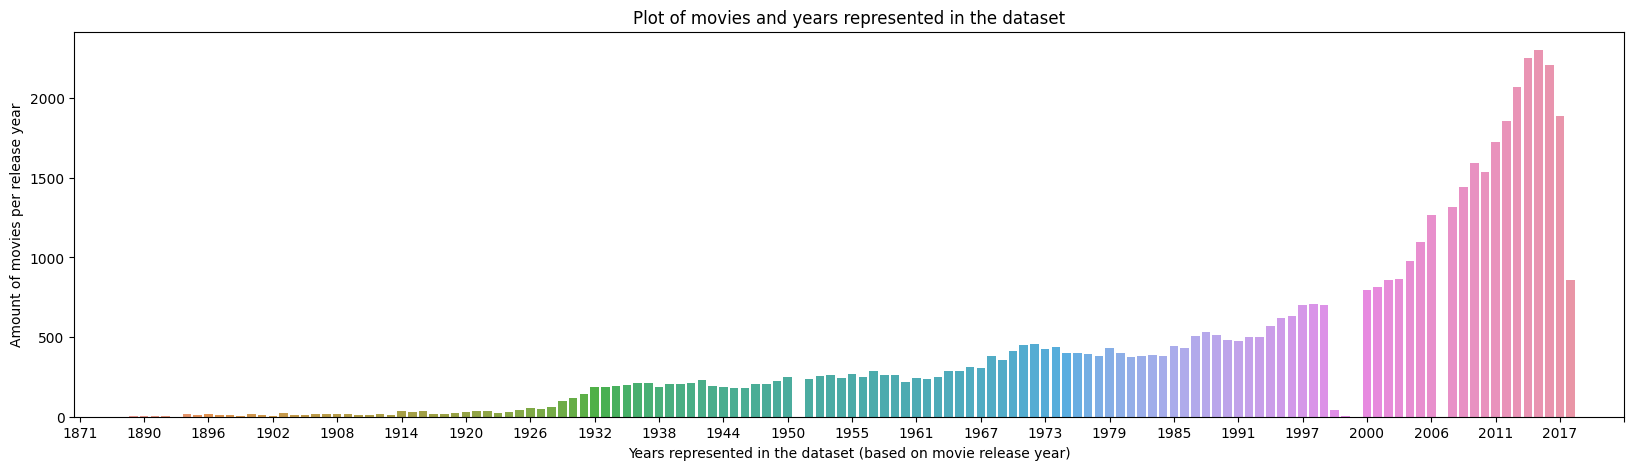

In [307]:
#setting figure size
plt.figure(figsize= (20,5))
sns.barplot(data = title_sum, y= 'title', x = 'year').set(title = 'Plot of movies and years represented in the dataset') #loading x,y axis and setting title
plt.xlabel("Years represented in the dataset (based on movie release year)") # X label title
plt.ylabel("Amount of movies per release year") #y label title
plt.xticks(np.arange(0, 150, 6)) #changing tick freqency on the x axis
plt.show()


### Sum of ratings against movieId
Starting by seeing if it needs to be cleansed

In [312]:
#No missing values
df_ratings.isna().any()


userId     False
movieId    False
rating     False
dtype: bool

In [325]:
print(df_ratings['userId'].min())
print(df_ratings['userId'].max(), "\n")
print(df_ratings['userId'].info(), "\n")
print(df_ratings['userId'].describe())


1
283228 

<class 'pandas.core.series.Series'>
RangeIndex: 27753444 entries, 0 to 27753443
Series name: userId
Non-Null Count     Dtype
--------------     -----
27753444 non-null  int32
dtypes: int32(1)
memory usage: 105.9 MB
None 

count    2.775344e+07
mean     1.419420e+05
std      8.170740e+04
min      1.000000e+00
25%      7.117600e+04
50%      1.420220e+05
75%      2.124590e+05
max      2.832280e+05
Name: userId, dtype: float64


In [326]:
print(df_ratings['movieId'].min())
print(df_ratings['movieId'].max(), "\n")
print(df_ratings['movieId'].info(), "\n")
print(df_ratings['movieId'].describe())

1
193886 

<class 'pandas.core.series.Series'>
RangeIndex: 27753444 entries, 0 to 27753443
Series name: movieId
Non-Null Count     Dtype
--------------     -----
27753444 non-null  int32
dtypes: int32(1)
memory usage: 105.9 MB
None 

count    2.775344e+07
mean     1.848800e+04
std      3.510263e+04
min      1.000000e+00
25%      1.097000e+03
50%      2.716000e+03
75%      7.150000e+03
max      1.938860e+05
Name: movieId, dtype: float64


In [327]:
print(df_ratings['rating'].min())
print(df_ratings['rating'].max(), "\n")
print(df_ratings['rating'].info(), "\n")
print(df_ratings['rating'].describe())

0.5
5.0 

<class 'pandas.core.series.Series'>
RangeIndex: 27753444 entries, 0 to 27753443
Series name: rating
Non-Null Count     Dtype  
--------------     -----  
27753444 non-null  float32
dtypes: float32(1)
memory usage: 105.9 MB
None 

count    2.775344e+07
mean     3.530446e+00
std      1.066353e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64
